# Small Crimes investigation

This notebook contains a partial explorative analysis on a [crimes investigation dataset](https://data.cityofchicago.org/Public-Safety/Crimes-2001-to-present/ijzp-q8t2). Download the dataset into the relative directory `raw/crimes`. Attention: there are two `raw` folders, one for the used datasets, one for the unused (located in the directory of this notebook). Just extract the zip in there and run the notebook

Attached the dir

```bash
> l raw
drwxr-xr-x  2 juli users 4.0K Dec 11 21:01 mobile
drwxr-xr-x  2 juli users 4.0K Dec 11 21:01 crimes
drwxr-xr-x  2 juli users 4.0K Dec 11 19:27 planets
drwxr-xr-x  2 juli users 4.0K Dec 12 12:42 power
drwxr-xr-x 21 juli users 4.0K May 14  2013 sports
```

In [1]:
import matplotlib.pyplot as plt
%matplotlib notebook
from explCrimes import *

from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt
from matplotlib import offsetbox
from sklearn import (manifold, datasets, decomposition, ensemble,
                     discriminant_analysis, random_projection)

In [2]:
k = CrimesAnalysis()

/usr/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2910: DtypeWarning: Columns (17,20) have mixed types. Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [6]:
k.data.shape

(1923515, 24)

#  Step 1 - Data cleansing


For getting to know the data a little bit better, make a sample and store it. 
```bash
head -n 100 Chicago_Crimes_2001_to_2004.csv > sample.csv
```

Our first step was to inspect the csv - able data as it is. Observations:
- Location, if given, spearated into two fileds in a strange format


In [7]:
_, ID_ID, ID_CASENR, ID_DATE, ID_BLOCK, ID_IUCR, ID_PRIM_TYPE, _, _, ID_ARREST, ID_DOMESTIC, \
ID_BEAT, ID_DISTRICT, _, _, _, ID_X, ID_Y, _, _, ID_LAT, ID_LON, _ = np.arange(23)

## Step 1a) - Inspecting raw data as it is loaded into our program

In [8]:
## Inspecting data
domestic = k.data[:,ID_DOMESTIC]             #< bool. Domestic issue? Seems very much correlated with the type
types    = k.data[:,ID_PRIM_TYPE]            #<  the different types of crimes. Printed below
allTypes = np.unique(types)                  #
arrested = k.data[:,ID_ARREST]               #< bool.

# Most interesting: Lat, lon
pos      = k.data[:, ID_LAT:ID_LON+1]

print(allTypes, domestic, arrested)

['ARSON' 'ASSAULT' 'BATTERY' 'BURGLARY' 'CRIM SEXUAL ASSAULT'
 'CRIMINAL DAMAGE' 'CRIMINAL TRESPASS' 'DECEPTIVE PRACTICE'
 'DOMESTIC VIOLENCE' 'GAMBLING' 'HOMICIDE'
 'INTERFERENCE WITH PUBLIC OFFICER' 'INTIMIDATION' 'KIDNAPPING'
 'LIQUOR LAW VIOLATION' 'MOTOR VEHICLE THEFT' 'NARCOTICS' 'NON-CRIMINAL'
 'OBSCENITY' 'OFFENSE INVOLVING CHILDREN' 'OTHER NARCOTIC VIOLATION'
 'OTHER OFFENSE' 'PROSTITUTION' 'PUBLIC INDECENCY' 'PUBLIC PEACE VIOLATION'
 'RITUALISM' 'ROBBERY' 'SEX OFFENSE' 'STALKING' 'THEFT' 'WEAPONS VIOLATION'] [False True False ..., False False False] [False False False ..., False False False]


Like we do have a lot of data, we are able to remove those entries with `location == nan`.

Plus, we want to define some other custom filters. Filtering for 
- THEFT , BURGLARY, 
- Whehter the person has been arrested
- Domestic issues (beeting and stuff)

In [9]:

combi = [np.sum(types == t) for t in allTypes]
for i, am in enumerate(combi):
    print(am, "    \t", allTypes[i])

3828     	 ARSON
121417     	 ASSAULT
363538     	 BATTERY
101902     	 BURGLARY
7079     	 CRIM SEXUAL ASSAULT
220298     	 CRIMINAL DAMAGE
57770     	 CRIMINAL TRESPASS
55751     	 DECEPTIVE PRACTICE
2     	 DOMESTIC VIOLENCE
4051     	 GAMBLING
3172     	 HOMICIDE
1701     	 INTERFERENCE WITH PUBLIC OFFICER
1312     	 INTIMIDATION
3022     	 KIDNAPPING
5384     	 LIQUOR LAW VIOLATION
98924     	 MOTOR VEHICLE THEFT
210600     	 NARCOTICS
1     	 NON-CRIMINAL
74     	 OBSCENITY
11181     	 OFFENSE INVOLVING CHILDREN
22     	 OTHER NARCOTIC VIOLATION
123753     	 OTHER OFFENSE
25666     	 PROSTITUTION
29     	 PUBLIC INDECENCY
10145     	 PUBLIC PEACE VIOLATION
15     	 RITUALISM
70986     	 ROBBERY
8535     	 SEX OFFENSE
868     	 STALKING
395395     	 THEFT
17094     	 WEAPONS VIOLATION


In [10]:
lat, lan = pos.T

### Definition of Filters 
for cleansing

In [11]:
cleansingFilter = ((lat == lat).astype(int) * (lan == lan).astype(int)).astype("bool")


for filtering


In [12]:
# types
# # domestic
isDomestic = (types == "DOMESTIC VIOLENCE").astype(bool)#< Domestic issues are negligable
print(np.sum(isDomestic))
isDomestic = (domestic).astype(bool)

# # theft / burglary
isTheft = ((types == "THEFT").astype(bool).astype("int") + (types == "ROBBERY").astype(bool).astype("int") + (types == "BURGLARY").astype(bool).astype(int)).astype(bool)

isProstitution = (types == "PROSTITUTION").astype(bool)
isMurder = (types == "HOMICIDE").astype(bool)

isSexOffense = (types == "SEX OFFENSE").astype(bool)
isNarcotics = (types == "NARCOTICS").astype(bool)
isArrested = (arrested).astype(bool)

# 

2


### Filter combinations for ease of switching

In [13]:
# a) no filter
accFilter = cleansingFilter
title = "only cleansing"

In [14]:
# isDomestic
accFilter = (cleansingFilter.astype(int) * isDomestic.astype(int)).astype(bool)
title = "isDomestic"

In [34]:
# theft
accFilter = (cleansingFilter.astype(int) * isTheft.astype(int)).astype(bool)
title = "theft"

In [16]:
# murder
accFilter =  (cleansingFilter.astype(int) * isMurder.astype(int)).astype(bool)
title = "isMurder"

In [17]:
# NARCOTICS
accFilter = (cleansingFilter.astype(int) * isNarcotics.astype(int)).astype(bool)
title = "NARCOTICS"

In [18]:
# sex offense
accFilter = (cleansingFilter.astype(int) * isSexOffense.astype(int)).astype(bool)
title = "sex offense"

In [19]:
# prosititution
accFilter = (cleansingFilter.astype(int) * isProstitution.astype(int)).astype(bool)
title = "prosititution"

In [20]:
# Accumulative: arrested
accFilter = (accFilter.astype(int) * isArrested.astype(int)).astype(bool)

title = title + " and arrested"

In [21]:
print(np.sum(accFilter))

25152


In [22]:
# Application of filter

In [37]:
cleaned = pos[accFilter]
cleaned.astype("float")
realTitle = title
cleaned.astype("float")

array([[ 41.69178464, -87.63511597],
       [ 41.86977216, -87.70818016],
       [ 41.72433049, -87.63843425],
       ..., 
       [ 41.74386544, -87.67446373],
       [ 41.73634266, -87.55541309],
       [ 41.77242071, -87.6093871 ]])

<IPython.core.display.Javascript object>


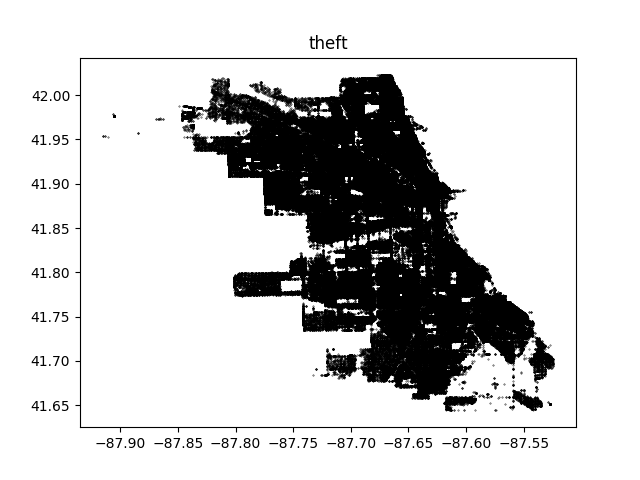

In [46]:
plt.figure()
plt.title(realTitle)
plt.scatter(cleaned[:,1], cleaned[:,0], c="black", s=.1)

# inspecting temporal pattern

In [43]:
ls = np.linspace(0, 1, cleaned.shape[0])[:,np.newaxis]
ml = np.array([0,1,1])[np.newaxis,:]
print(ml.shape, ls.shape)
clr1 = ls * ml
print(clr1.shape)
clr = clr1 + [1,0,0]

(1, 3) (558567, 1)
(558567, 3)


<IPython.core.display.Javascript object>


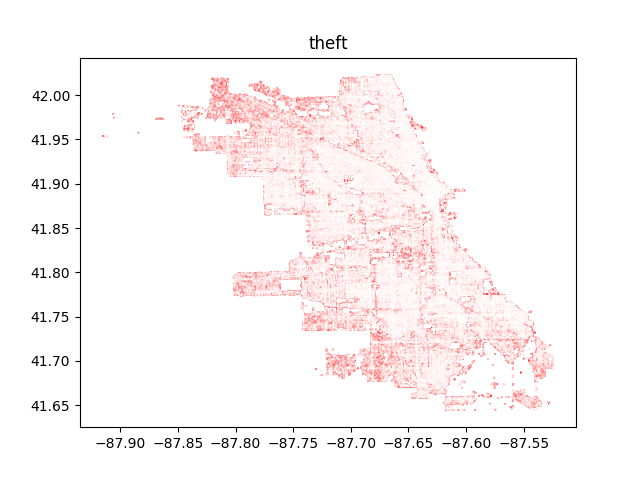

In [47]:
plt.figure()
plt.title(realTitle)
plt.scatter(cleaned[:,1], cleaned[:,0], c=clr, s=.1)

In [27]:
cleaned = cleaned.astype("float")

In [28]:
amount = 500
num = int(np.floor(cleaned.shape[0]/amount))
cleanedBatch = np.array([np.mean(cleaned[i*num:(i+1)*num,:],axis=0) for i in np.arange(amount)])
cleanedBatchV = np.array([np.var(cleaned[i*num:(i+1)*num,:],axis=1) for i in np.arange(amount)])

In [29]:
cleanedBatch.shape

(500, 2)

<IPython.core.display.Javascript object>


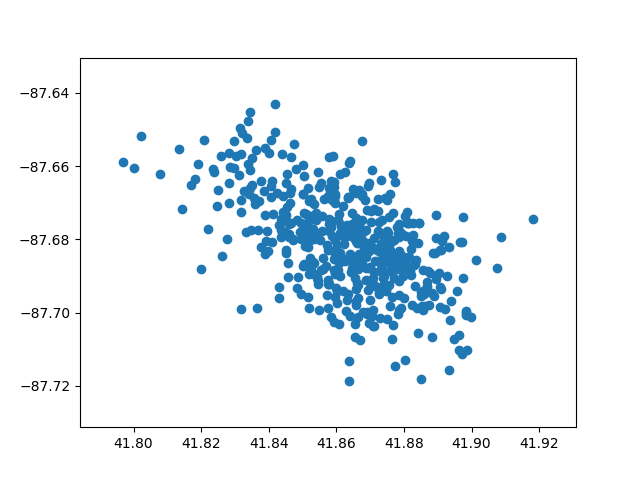

In [30]:
plt.figure()
plt.scatter(cleanedBatch[:,0], cleanedBatch[:,1])


<IPython.core.display.Javascript object>


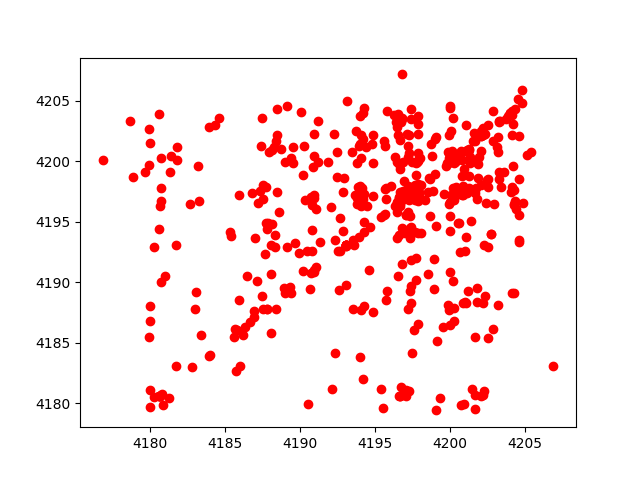

In [31]:
plt.figure()
plt.scatter(cleanedBatchV[:,0], cleanedBatchV[:,1], c="red")

In [59]:
amount = 100
num = int(np.floor(cleaned.shape[0]/amount))
cleanedBatch = np.array([cleaned[i*num:(i+1)*num,:] for i in np.arange(amount)])


<IPython.core.display.Javascript object>


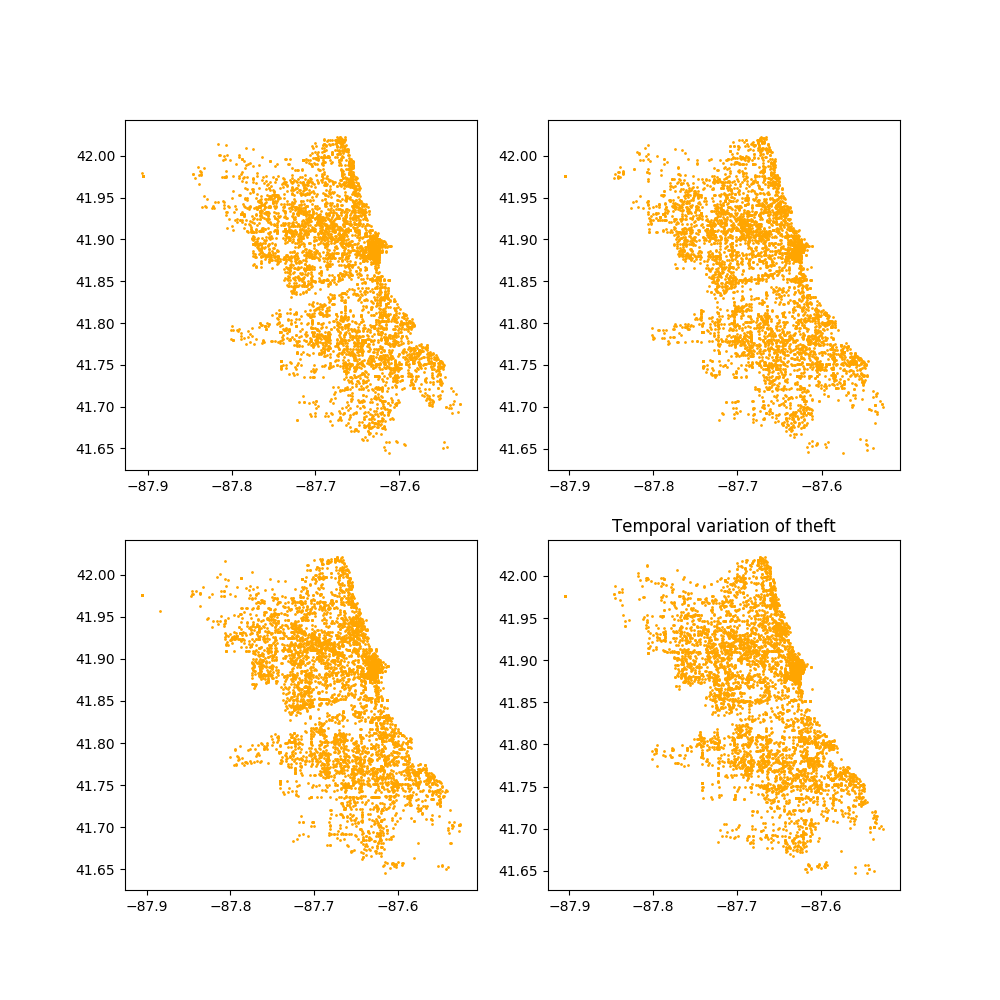

Text(0.5,1,'Temporal variation of theft')

In [63]:
plt.figure(figsize=(10,10))
plt.title("Temporal variation of " + realTitle)
for i in np.arange(4):
    plt.subplot(2,2, i+1)
    cleanedI = cleanedBatch[i]
    plt.scatter(cleanedI[:,1], cleanedI[:,0], s=1, color="orange")
plt.title("Temporal variation of " + realTitle)